In [31]:
import numpy as np 
import pandas as pd 
import cv2
import scipy
import math
import os, random
from skimage.metrics import structural_similarity
from PIL import Image
from numpy import r_
from scipy import fftpack
from matplotlib import pyplot as plt
%matplotlib inline


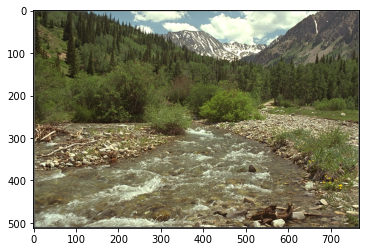

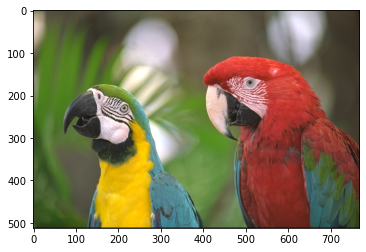

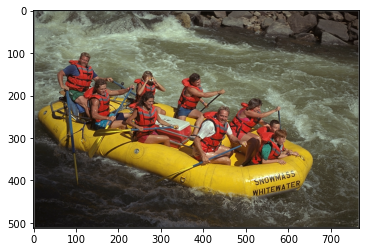

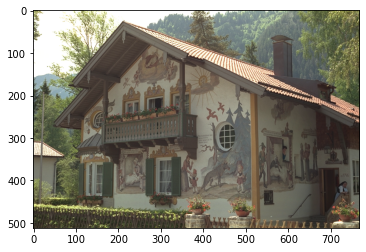

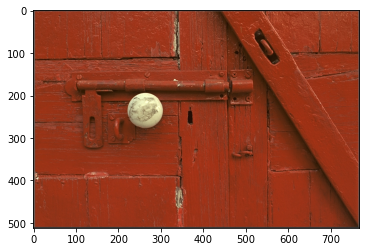

In [32]:
# PLOT 5 RANDOM IMAGES

for i in range(5):
    randImagePath = os.path.join('Kodak/', np.random.choice((os.listdir("Kodak"))))
    img = Image.open(randImagePath)
    # img = cv2.imread(randImagePath)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f = plt.figure()
    plt.imshow(img)


In [33]:
# UTILITY FUNCTIONS

def load_image(path):
    """ Load image from path. Return a numpy array """
    image = Image.open(path)
    return np.asarray(image) #/ 255

def showImage(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

def PlotGraphs(data, label_x):
  x=data[0]
  y=data[1]
  z=data[2]
  w=data[3]

  plt.scatter(x, y,c='red')
  plt.plot(x, y)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("CR")
  plt.show()

  plt.scatter(x, z,c='green')
  plt.plot(x, z)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("PSNR")
  plt.show()

  plt.scatter(x, w,c='blue')
  plt.plot(x, w)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("SSIM")
  plt.show()

In [40]:
def dct2(a):
    return fftpack.dct(fftpack.dct(a, axis=0, norm='ortho').T, axis=1, norm='ortho').T

def idct2(a):
    return fftpack.idct(fftpack.idct(a, axis=0 , norm='ortho').T, axis=1 , norm='ortho').T

# def dct2(a):
#     return cv2.dct(a)

# def idct2(a):
#     return cv2.dct(a, flags = 1)


def getLuminanceQuantizationMatrix(quality = 50):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])
    
    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if quality == 10:
        return Q10
    elif quality == 50:
        return Q50
    elif quality == 90:
        return Q90
    else:
        return np.ones((8,8))
    
def getChrominanceQuantizationMatrix(quality = 50):
    Q = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                  [18, 21, 26, 66, 99, 99, 99, 99],
                  [24, 26, 56, 99, 99, 99, 99, 99],
                  [47, 66, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99]], dtype=int)

    if(quality >= 100):
        return np.ones((8,8))
    if(quality <= 0):
        quality = 1
    if(quality < 50):
        qualityScale = 5000 / quality
    else:
        qualityScale = 200 - quality * 2
    chrominanceQuantTbl = np.array(np.floor((Q * qualityScale + 50) / 100))
    chrominanceQuantTbl[chrominanceQuantTbl == 0] = 1
    chrominanceQuantTbl[chrominanceQuantTbl > 255] = 255
    chrominanceQuantTbl = chrominanceQuantTbl.reshape([8, 8]).astype(int)
    return chrominanceQuantTbl

def DCT_compression(im, threshold, Lquality, Cquality):    

    imsize = im.shape
    Height = imsize[0]
    Width = imsize[1]
    srcImageMatrix = im
    addedImageMatrix = np.zeros(imsize, dtype=np.uint8)
    for y in range(Height):
        for x in range(Width):
            addedImageMatrix[y][x] = srcImageMatrix[y][x]
            
    yImage,uImage,vImage = Image.fromarray(addedImageMatrix).convert('YCbCr').split()
    yImageMatrix = np.asarray(yImage)
    uImageMatrix = np.asarray(uImage)
    vImageMatrix = np.asarray(vImage)

    LQ = getLuminanceQuantizationMatrix(Lquality)
    CQ = getChrominanceQuantizationMatrix(Cquality)
   
    # dct = np.zeros(imsize)
    
    # Do 8x8 DCT on image (in-place)
    # for i in r_[:imsize[0]:8]:
    #     for j in r_[:imsize[1]:8]:
    #         dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)])

    yDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vDctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    Y_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    U_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    V_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)

    
    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yDctMatrix[y:y + 8, x:x + 8] = dct2(yImageMatrix[y:y + 8, x:x + 8])
            uDctMatrix[y:y + 8, x:x + 8] = dct2(uImageMatrix[y:y + 8, x:x + 8])
            vDctMatrix[y:y + 8, x:x + 8] = dct2(vImageMatrix[y:y + 8, x:x + 8])

            yQuantMatrix[y:y + 8, x:x + 8] = yDctMatrix[y:y + 8, x:x + 8] // LQ
            uQuantMatrix[y:y + 8, x:x + 8] = uDctMatrix[y:y + 8, x:x + 8] // CQ
            vQuantMatrix[y:y + 8, x:x + 8] = vDctMatrix[y:y + 8, x:x + 8] // CQ

    #  Threshold
    Y_dct_thresh = yQuantMatrix * (abs(yQuantMatrix) > (threshold*np.max(yQuantMatrix)))
    percent_nonzeros = np.sum( Y_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of Y Matrix")


    U_dct_thresh = uQuantMatrix * (abs(uQuantMatrix) > (threshold*np.max(uQuantMatrix)))
    percent_nonzeros = np.sum( U_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of U Matrix")


    V_dct_thresh = vQuantMatrix * (abs(vQuantMatrix) > (threshold*np.max(vQuantMatrix)))
    percent_nonzeros = np.sum( V_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of V Matrix")

    # im_dct = np.zeros(imsize)#regained image

    # for i in r_[:imsize[0]:8]:
    #     for j in r_[:imsize[1]:8]:
    #         im_dct[i:(i+8),j:(j+8)] = idct2(dct_thresh[i:(i+8),j:(j+8)]) 

    # im_dct = im_dct.astype(np.uint8)
    # return im_dct

    # for y in range(0, Height, 8):
    #     for x in range(0, Width, 8):
    #         yReversedQuantMatrix[y:y + 8, x:x + 8] = Y_dct_thresh[y:y + 8, x:x + 8]*LQ
    #         uReversedQuantMatrix[y:y + 8, x:x + 8] = U_dct_thresh[y:y + 8, x:x + 8]*CQ
    #         vReversedQuantMatrix[y:y + 8, x:x + 8] = V_dct_thresh[y:y + 8, x:x + 8]*CQ

    #         yIdctMatrix[y:y + 8, x:x + 8] = idct2(yReversedQuantMatrix[y:y + 8, x:x + 8])
    #         uIdctMatrix[y:y + 8, x:x + 8] = idct2(uReversedQuantMatrix[y:y + 8, x:x + 8])
    #         vIdctMatrix[y:y + 8, x:x + 8] = idct2(vReversedQuantMatrix[y:y + 8, x:x + 8])

    # Y = Image.fromarray(yIdctMatrix)
    # U = Image.fromarray(uIdctMatrix)
    # V = Image.fromarray(vIdctMatrix)

    Y = Image.fromarray(Y_dct_thresh)
    U = Image.fromarray(U_dct_thresh)
    V = Image.fromarray(V_dct_thresh)
    
    merged_YUV = Image.merge('YCbCr', (Y, U, V)) 
    rgb_img = merged_YUV.convert('RGB') 
    
    return rgb_img

    


In [35]:
def reverse_compression(im, Lquality, Cquality):
    imsize = im.shape
    Height = imsize[0]
    Width = imsize[1]
    srcImageMatrix = im
    addedImageMatrix = np.zeros(imsize, dtype=np.uint8)
    for y in range(Height):
        for x in range(Width):
            addedImageMatrix[y][x] = srcImageMatrix[y][x]
            
    yImage,uImage,vImage = Image.fromarray(addedImageMatrix).convert('YCbCr').split()
    yImageMatrix = np.asarray(yImage)
    uImageMatrix = np.asarray(uImage)
    vImageMatrix = np.asarray(vImage)

    LQ = getLuminanceQuantizationMatrix(Lquality)
    CQ = getChrominanceQuantizationMatrix(Cquality)

    yReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yReversedQuantMatrix[y:y + 8, x:x + 8] = yImageMatrix[y:y + 8, x:x + 8]*LQ
            uReversedQuantMatrix[y:y + 8, x:x + 8] = uImageMatrix[y:y + 8, x:x + 8]*CQ
            vReversedQuantMatrix[y:y + 8, x:x + 8] = vImageMatrix[y:y + 8, x:x + 8]*CQ

            yIdctMatrix[y:y + 8, x:x + 8] = idct2(yReversedQuantMatrix[y:y + 8, x:x + 8])
            uIdctMatrix[y:y + 8, x:x + 8] = idct2(uReversedQuantMatrix[y:y + 8, x:x + 8])
            vIdctMatrix[y:y + 8, x:x + 8] = idct2(vReversedQuantMatrix[y:y + 8, x:x + 8])

    Y = Image.fromarray(yIdctMatrix)
    U = Image.fromarray(uIdctMatrix)
    V = Image.fromarray(vIdctMatrix)

    merged_YUV = Image.merge('YCbCr', (Y, U, V)) 
    rgb_img = merged_YUV.convert('RGB') 
    
    return rgb_img

In [36]:
# FUNCTIONS TO CALCULATE METRICS

def psnr(original, compressed):
    mse = np.mean( (original - compressed) ** 2 )
    if mse == 0:
        return 100 
    PIXEL_MAX = 255.0
    PSNR = round((20 * math.log10(PIXEL_MAX / math.sqrt(mse))), 3)
    print("Achieved Peak Signal to Noise Ratio: " + str(PSNR))
    return PSNR

def ssim(original, compressed):
    meanSSIM = structural_similarity(original, compressed, multichannel=True)
    SSIM = round(meanSSIM, 3) 
    print("Achieved SSIM: " + str(round(meanSSIM, 3)))
    return SSIM
    
# def cr2(original, compressed):
#     nonZerosInOriginal = np.sum(original!=0)
#     nonZerosInCompressed = np.sum(compressed!=0)
#     return round(nonZerosInOriginal/nonZerosInCompressed, 3)
    
def cr(original_img, compressed_img):
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

    original_img=cv2.imwrite("original.png", original_img)
    print("Original File Size: "+str(os.path.getsize("original.png")))
    
    compressed_img=cv2.imwrite("compressed.png", compressed_img)
    print("Compressed File Size: "+str(os.path.getsize("compressed.png")))
    CR = round(os.path.getsize("original.png")/os.path.getsize("compressed.png"), 3)
    print("Achieved Compression Ratio: " + str(CR))  
    return CR
        
# def metricsCR( original_img, compressed_img ):
    # print("Achieved Peak Signal to Noise Ratio: " + str(psnr(original_img, compressed_img)))
    # print("Achieved SSIM : " + str(ssim(original_img, compressed_img)))
    # print("Achieved Compression Ratio: " + str(cr(original_img, compressed_img)))  
    # return cr(original_img, compressed_img)

# def metricsPSNRSSIM( original_img, compressed_img ):
#     print("Achieved Peak Signal to Noise Ratio: " + str(psnr(original_img, compressed_img)))
#     print("Achieved SSIM : " + str(ssim(original_img, compressed_img)))
#     # print("Achieved Compression Ratio: " + str(cr(original_img, compressed_img)))  
#     return psnr(original_img, compressed_img), ssim(original_img, compressed_img)



Keeping only 74.57 % of the DCT coefficients of Y Matrix
Keeping only 87.51 % of the DCT coefficients of U Matrix
Keeping only 87.54 % of the DCT coefficients of V Matrix
Original File Size: 915652
Compressed File Size: 802135
Achieved Compression Ratio: 1.142
Achieved Peak Signal to Noise Ratio: 28.75
Achieved SSIM: 0.32


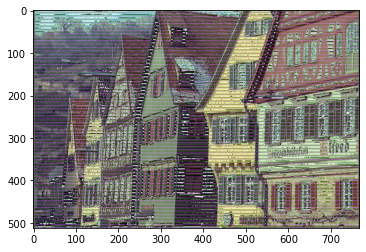

In [76]:
# RUNNING METRICS FOR 1 IMAGE

image = load_image("Kodak/kodim08.png")
# image = load_image("Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1).jpg")
X_compressed = np.asarray(DCT_compression(image, 0.2, 100, 100))
cr(image, X_compressed)
X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
psnr(image, X_reconstructed)
ssim(image, X_reconstructed)
plt.imshow(X_reconstructed)


Testing for threshold = 0.0
Keeping only 99.74 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 856862
Achieved Compression Ratio: 1.069
Achieved Peak Signal to Noise Ratio: 29.128
Achieved SSIM: 0.404
Testing for threshold = 0.1
Keeping only 90.32 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 851782
Achieved Compression Ratio: 1.075
Achieved Peak Signal to Noise Ratio: 28.994
Achieved SSIM: 0.384
Testing for threshold = 0.2
Keeping only 74.57 % of the DCT coefficients of Y Matrix
Keeping only 87.51 % of the DCT coefficients of U Matrix
Keeping only 87.54 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed F

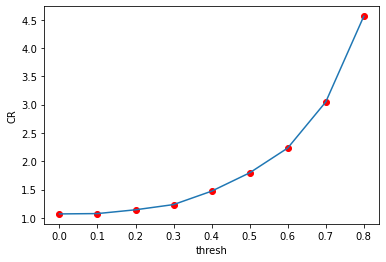

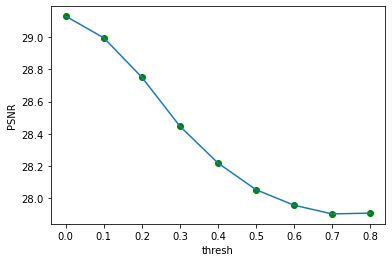

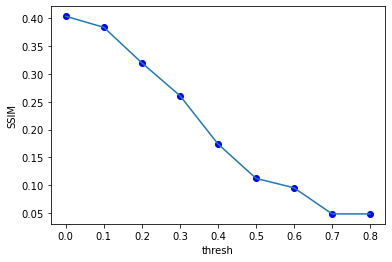

In [53]:
# Plotting graphs for 1 image
image = load_image("Kodak/kodim08.png")
# image = load_image("Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1).jpg")
thresh = 0.0
threshMax = 0.8
step = 0.1
i=0
noOfMetrics = 3 
eval_data = np.zeros(((int((threshMax-thresh)/step))+1, noOfMetrics + 1), dtype=float)#col1=thresh, col2=cr, col3=psnr, col4=ssim
while thresh<=threshMax:
  eval_data[i][0] = thresh
  print("Testing for threshold = "+str(thresh))
  X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )#DCT Transform 
  X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
  print("Metrics otained: ")
  eval_data[i][1] = cr(image, X_compressed)
  eval_data[i][2] = psnr(image, X_reconstructed)
  eval_data[i][3] = ssim(image, X_reconstructed)
  thresh+=0.1
  i+=1
print("Data obtained after evaluation: ")
print(eval_data)
PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')

In [67]:
# CALCULATE AVERAGE METRICS
import time
folderName = 'Kodak'
# folderName = 'Dataset4K'
CR_LIST = []
PSNR_LIST = []
SSIM_LIST = []
thresh = 0.20
start_time = time.time()

for fileName in (os.listdir(folderName)):
    imagePath = os.path.join(folderName, fileName)
    image = load_image(imagePath)
    X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )
    X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
    CR = cr(image, X_compressed)
    PSNR = psnr(image, X_reconstructed)
    SSIM = ssim(image, X_reconstructed)
    end_time = time.time()
    CR_LIST.append(CR)
    PSNR_LIST.append(PSNR)
    SSIM_LIST.append(SSIM)

print("MEAN CR = ", sum(CR_LIST)/len(CR_LIST))
print("MEAN PSNR = ", sum(PSNR_LIST)/len(PSNR_LIST))
print("MEAN SSIM = ", sum(SSIM_LIST)/len(SSIM_LIST))
print("TOTAL RUNNING TIME = ", end_time - start_time)

Keeping only 79.97 % of the DCT coefficients of Y Matrix
Keeping only 87.73 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Original File Size: 857993
Compressed File Size: 752502
Achieved Compression Ratio: 1.14
Achieved Peak Signal to Noise Ratio: 29.067
Achieved SSIM: 0.388
Keeping only 72.62 % of the DCT coefficients of Y Matrix
Keeping only 87.72 % of the DCT coefficients of U Matrix
Keeping only 87.26 % of the DCT coefficients of V Matrix
Original File Size: 681895
Compressed File Size: 565774
Achieved Compression Ratio: 1.205
Achieved Peak Signal to Noise Ratio: 28.558
Achieved SSIM: 0.188
Keeping only 75.76 % of the DCT coefficients of Y Matrix
Keeping only 83.97 % of the DCT coefficients of U Matrix
Keeping only 87.14 % of the DCT coefficients of V Matrix
Original File Size: 591916
Compressed File Size: 505499
Achieved Compression Ratio: 1.171
Achieved Peak Signal to Noise Ratio: 28.978
Achieved SSIM: 0.241
Keeping only 74.92 % of

In [49]:
# CALCULATE TIME FOR COMPRESSION
import time
folderName = 'Kodak'
# folderName = 'Dataset4K'
thresh = 0.2
start_time = time.time()

for fileName in (os.listdir(folderName)):
    imagePath = os.path.join(folderName, fileName)
    image = load_image(imagePath)
    X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )
    end_time = time.time()

print("TOTAL COMPRESSION TIME = ", end_time - start_time)

Keeping only 79.97 % of the DCT coefficients of Y Matrix
Keeping only 87.73 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Keeping only 72.62 % of the DCT coefficients of Y Matrix
Keeping only 87.72 % of the DCT coefficients of U Matrix
Keeping only 87.26 % of the DCT coefficients of V Matrix
Keeping only 75.76 % of the DCT coefficients of Y Matrix
Keeping only 83.97 % of the DCT coefficients of U Matrix
Keeping only 87.14 % of the DCT coefficients of V Matrix
Keeping only 74.92 % of the DCT coefficients of Y Matrix
Keeping only 87.54 % of the DCT coefficients of U Matrix
Keeping only 87.41 % of the DCT coefficients of V Matrix
Keeping only 62.59 % of the DCT coefficients of Y Matrix
Keeping only 87.31 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Keeping only 80.69 % of the DCT coefficients of Y Matrix
Keeping only 87.55 % of the DCT coefficients of U Matrix
Keeping only 87.51 % of the DCT

Testing for threshold = 0.0
Keeping only 99.86 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 857993
Compressed File Size: 798842
Achieved Compression Ratio: 1.074
Achieved Peak Signal to Noise Ratio: 29.535
Achieved SSIM: 0.486
Testing for threshold = 0.1
Keeping only 93.49 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 857993
Compressed File Size: 796284
Achieved Compression Ratio: 1.077
Achieved Peak Signal to Noise Ratio: 29.397
Achieved SSIM: 0.466
Testing for threshold = 0.2
Keeping only 79.97 % of the DCT coefficients of Y Matrix
Keeping only 87.73 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 857993
Compressed F

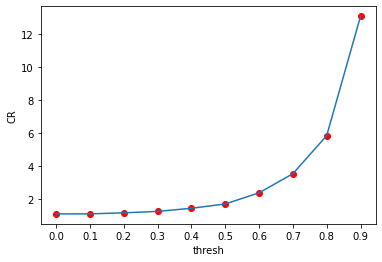

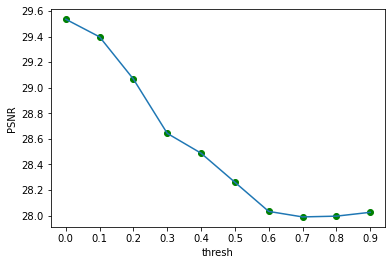

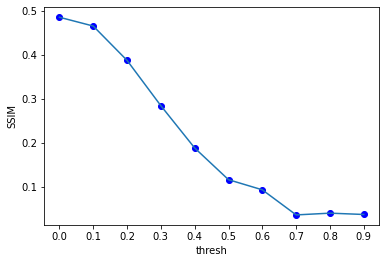

Testing for threshold = 0.0
Keeping only 99.94 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.81 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 681895
Compressed File Size: 623118
Achieved Compression Ratio: 1.094
Achieved Peak Signal to Noise Ratio: 29.187
Achieved SSIM: 0.375
Testing for threshold = 0.1
Keeping only 88.59 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.46 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 681895
Compressed File Size: 615010
Achieved Compression Ratio: 1.109
Achieved Peak Signal to Noise Ratio: 28.882
Achieved SSIM: 0.299
Testing for threshold = 0.2
Keeping only 72.62 % of the DCT coefficients of Y Matrix
Keeping only 87.72 % of the DCT coefficients of U Matrix
Keeping only 87.26 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 681895
Compressed F

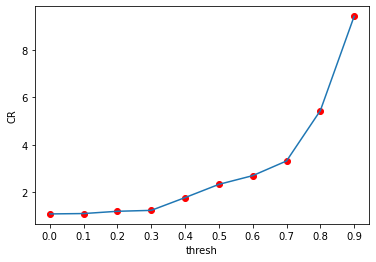

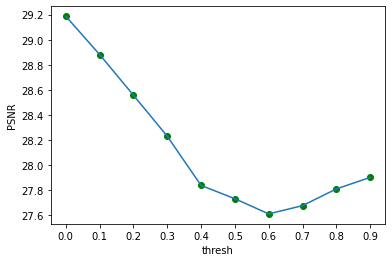

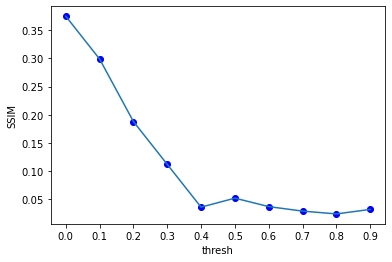

Testing for threshold = 0.0
Keeping only 99.95 % of the DCT coefficients of Y Matrix
Keeping only 99.99 % of the DCT coefficients of U Matrix
Keeping only 99.98 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 591916
Compressed File Size: 560745
Achieved Compression Ratio: 1.056
Achieved Peak Signal to Noise Ratio: 29.511
Achieved SSIM: 0.376
Testing for threshold = 0.1
Keeping only 92.39 % of the DCT coefficients of Y Matrix
Keeping only 98.01 % of the DCT coefficients of U Matrix
Keeping only 99.4 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 591916
Compressed File Size: 554123
Achieved Compression Ratio: 1.068
Achieved Peak Signal to Noise Ratio: 29.323
Achieved SSIM: 0.322
Testing for threshold = 0.2
Keeping only 75.76 % of the DCT coefficients of Y Matrix
Keeping only 83.97 % of the DCT coefficients of U Matrix
Keeping only 87.14 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 591916
Compressed Fi

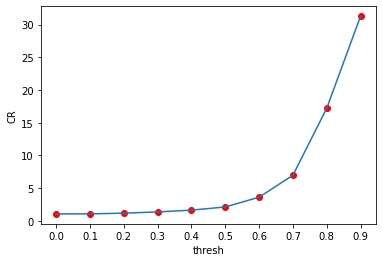

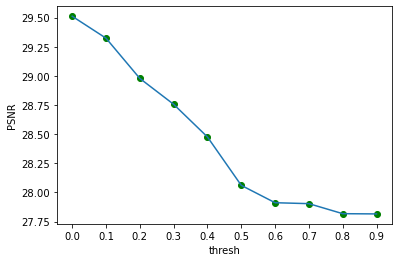

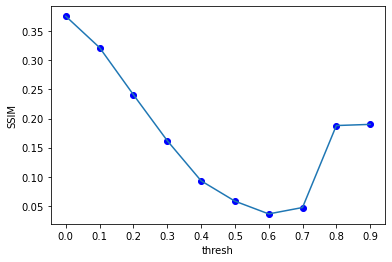

Testing for threshold = 0.0
Keeping only 99.73 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.94 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 711269
Compressed File Size: 654280
Achieved Compression Ratio: 1.087
Achieved Peak Signal to Noise Ratio: 29.376
Achieved SSIM: 0.392
Testing for threshold = 0.1
Keeping only 91.93 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.13 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 711269
Compressed File Size: 652936
Achieved Compression Ratio: 1.089
Achieved Peak Signal to Noise Ratio: 29.215
Achieved SSIM: 0.355
Testing for threshold = 0.2
Keeping only 74.92 % of the DCT coefficients of Y Matrix
Keeping only 87.54 % of the DCT coefficients of U Matrix
Keeping only 87.41 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 711269
Compressed F

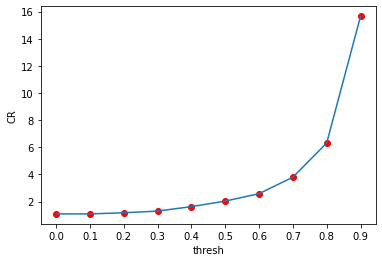

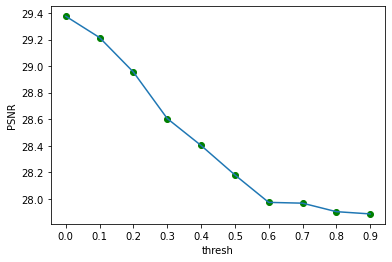

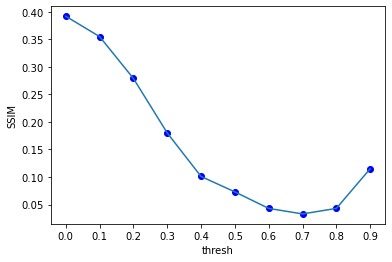

Testing for threshold = 0.0
Keeping only 99.47 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 866515
Compressed File Size: 813744
Achieved Compression Ratio: 1.065
Achieved Peak Signal to Noise Ratio: 29.225
Achieved SSIM: 0.372
Testing for threshold = 0.1
Keeping only 84.35 % of the DCT coefficients of Y Matrix
Keeping only 99.72 % of the DCT coefficients of U Matrix
Keeping only 99.86 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 866515
Compressed File Size: 803638
Achieved Compression Ratio: 1.078
Achieved Peak Signal to Noise Ratio: 28.993
Achieved SSIM: 0.328
Testing for threshold = 0.2
Keeping only 62.59 % of the DCT coefficients of Y Matrix
Keeping only 87.31 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 866515
Compressed F

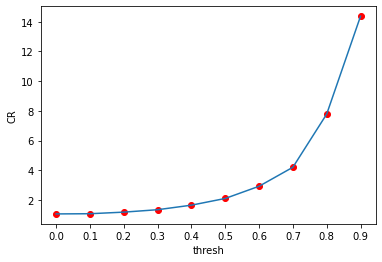

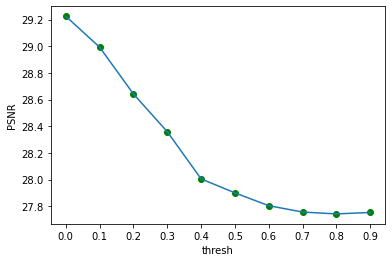

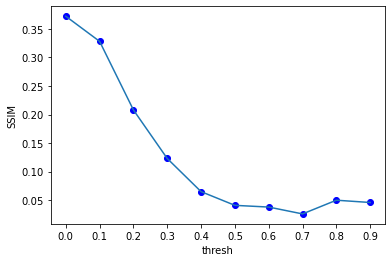

Testing for threshold = 0.0
Keeping only 99.82 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 717532
Compressed File Size: 680421
Achieved Compression Ratio: 1.055
Achieved Peak Signal to Noise Ratio: 29.101
Achieved SSIM: 0.366
Testing for threshold = 0.1
Keeping only 92.87 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 717532
Compressed File Size: 675991
Achieved Compression Ratio: 1.061
Achieved Peak Signal to Noise Ratio: 28.996
Achieved SSIM: 0.35
Testing for threshold = 0.2
Keeping only 80.69 % of the DCT coefficients of Y Matrix
Keeping only 87.55 % of the DCT coefficients of U Matrix
Keeping only 87.51 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 717532
Compressed Fi

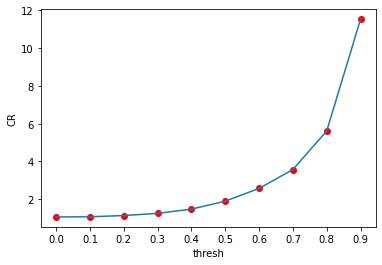

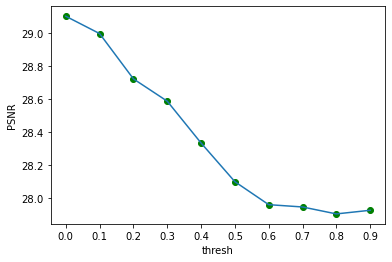

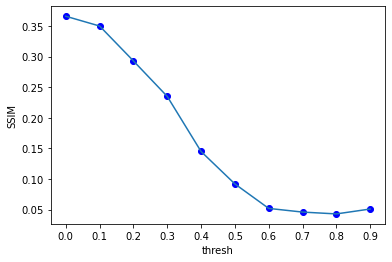

Testing for threshold = 0.0
Keeping only 99.85 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 635563
Compressed File Size: 605637
Achieved Compression Ratio: 1.049
Achieved Peak Signal to Noise Ratio: 29.552
Achieved SSIM: 0.411
Testing for threshold = 0.1
Keeping only 94.58 % of the DCT coefficients of Y Matrix
Keeping only 99.96 % of the DCT coefficients of U Matrix
Keeping only 99.73 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 635563
Compressed File Size: 601951
Achieved Compression Ratio: 1.056
Achieved Peak Signal to Noise Ratio: 29.448
Achieved SSIM: 0.395
Testing for threshold = 0.2
Keeping only 79.55 % of the DCT coefficients of Y Matrix
Keeping only 87.78 % of the DCT coefficients of U Matrix
Keeping only 87.4 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 635563
Compressed Fi

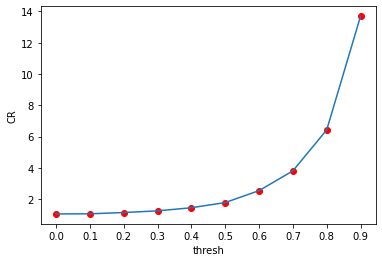

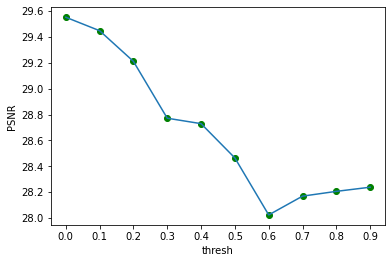

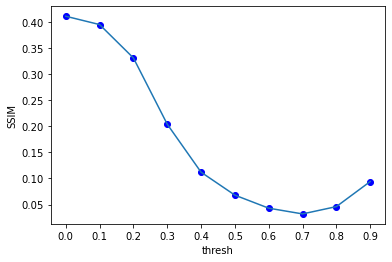

Testing for threshold = 0.0
Keeping only 99.74 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 856862
Achieved Compression Ratio: 1.069
Achieved Peak Signal to Noise Ratio: 29.128
Achieved SSIM: 0.404
Testing for threshold = 0.1
Keeping only 90.32 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 851782
Achieved Compression Ratio: 1.075
Achieved Peak Signal to Noise Ratio: 28.994
Achieved SSIM: 0.384
Testing for threshold = 0.2
Keeping only 74.57 % of the DCT coefficients of Y Matrix
Keeping only 87.51 % of the DCT coefficients of U Matrix
Keeping only 87.54 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed F

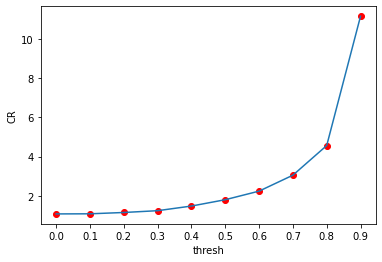

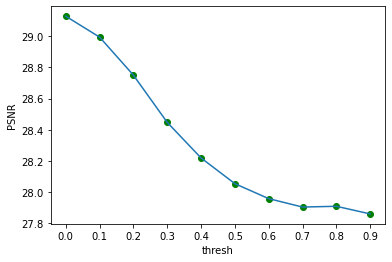

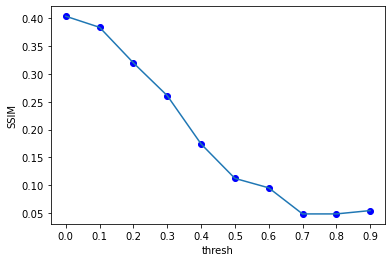

Testing for threshold = 0.0
Keeping only 99.7 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 660256
Compressed File Size: 613532
Achieved Compression Ratio: 1.076
Achieved Peak Signal to Noise Ratio: 29.547
Achieved SSIM: 0.393
Testing for threshold = 0.1
Keeping only 95.66 % of the DCT coefficients of Y Matrix
Keeping only 99.56 % of the DCT coefficients of U Matrix
Keeping only 99.98 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 660256
Compressed File Size: 611076
Achieved Compression Ratio: 1.08
Achieved Peak Signal to Noise Ratio: 29.482
Achieved SSIM: 0.38
Testing for threshold = 0.2
Keeping only 82.5 % of the DCT coefficients of Y Matrix
Keeping only 86.97 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 660256
Compressed File 

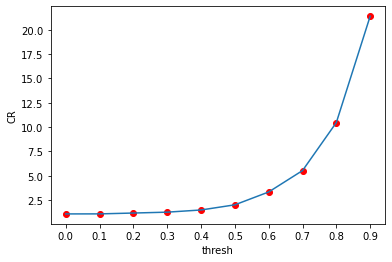

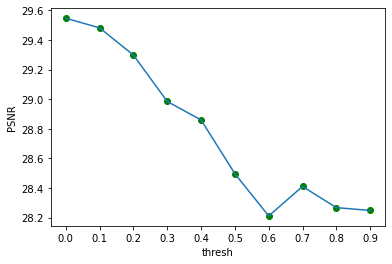

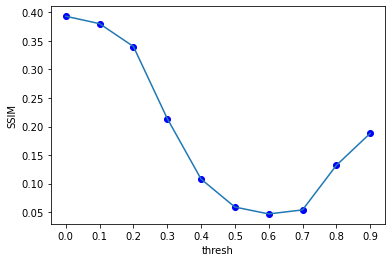

Testing for threshold = 0.0
Keeping only 99.69 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 677636
Compressed File Size: 634607
Achieved Compression Ratio: 1.068
Achieved Peak Signal to Noise Ratio: 29.61
Achieved SSIM: 0.392
Testing for threshold = 0.1
Keeping only 95.26 % of the DCT coefficients of Y Matrix
Keeping only 99.98 % of the DCT coefficients of U Matrix
Keeping only 99.97 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 677636
Compressed File Size: 633291
Achieved Compression Ratio: 1.07
Achieved Peak Signal to Noise Ratio: 29.521
Achieved SSIM: 0.375
Testing for threshold = 0.2
Keeping only 81.44 % of the DCT coefficients of Y Matrix
Keeping only 87.54 % of the DCT coefficients of U Matrix
Keeping only 87.48 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 677636
Compressed Fil

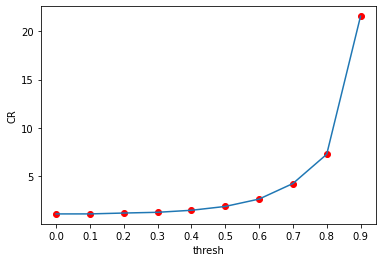

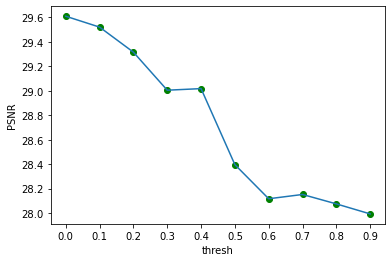

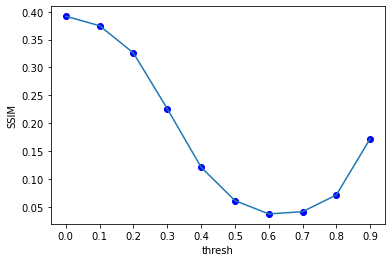

Testing for threshold = 0.0
Keeping only 99.84 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 716472
Compressed File Size: 671310
Achieved Compression Ratio: 1.067
Achieved Peak Signal to Noise Ratio: 29.557
Achieved SSIM: 0.391
Testing for threshold = 0.1
Keeping only 84.66 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.92 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 716472
Compressed File Size: 642876
Achieved Compression Ratio: 1.114
Achieved Peak Signal to Noise Ratio: 29.329
Achieved SSIM: 0.351
Testing for threshold = 0.2
Keeping only 68.85 % of the DCT coefficients of Y Matrix
Keeping only 87.51 % of the DCT coefficients of U Matrix
Keeping only 87.47 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 716472
Compressed F

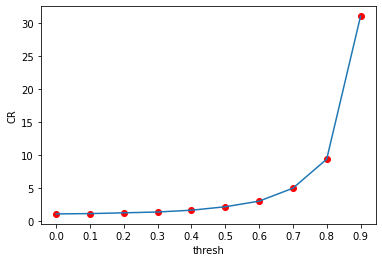

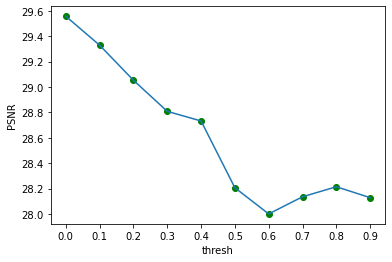

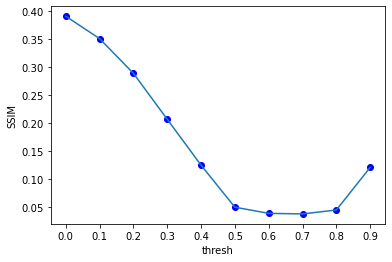

Testing for threshold = 0.0
Keeping only 99.85 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 619365
Compressed File Size: 581166
Achieved Compression Ratio: 1.066
Achieved Peak Signal to Noise Ratio: 28.954
Achieved SSIM: 0.305
Testing for threshold = 0.1
Keeping only 94.68 % of the DCT coefficients of Y Matrix
Keeping only 99.97 % of the DCT coefficients of U Matrix
Keeping only 99.96 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 619365
Compressed File Size: 576275
Achieved Compression Ratio: 1.075
Achieved Peak Signal to Noise Ratio: 28.919
Achieved SSIM: 0.295
Testing for threshold = 0.2
Keeping only 83.12 % of the DCT coefficients of Y Matrix
Keeping only 87.48 % of the DCT coefficients of U Matrix
Keeping only 87.5 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 619365
Compressed Fi

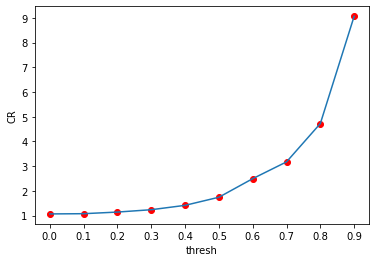

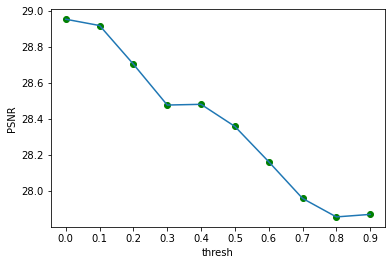

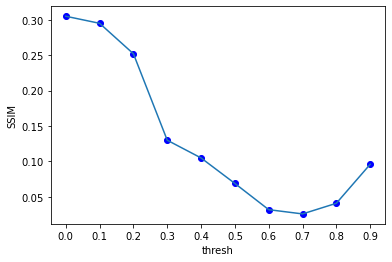

Testing for threshold = 0.0
Keeping only 99.73 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 923532
Compressed File Size: 867300
Achieved Compression Ratio: 1.065
Achieved Peak Signal to Noise Ratio: 29.277
Achieved SSIM: 0.417
Testing for threshold = 0.1
Keeping only 90.77 % of the DCT coefficients of Y Matrix
Keeping only 99.68 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 923532
Compressed File Size: 864416
Achieved Compression Ratio: 1.068
Achieved Peak Signal to Noise Ratio: 29.107
Achieved SSIM: 0.405
Testing for threshold = 0.2
Keeping only 75.38 % of the DCT coefficients of Y Matrix
Keeping only 87.25 % of the DCT coefficients of U Matrix
Keeping only 87.51 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 923532
Compressed F

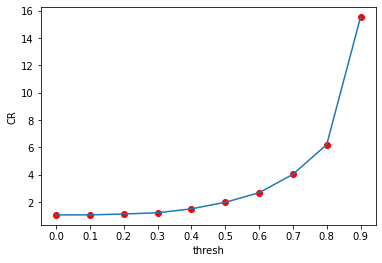

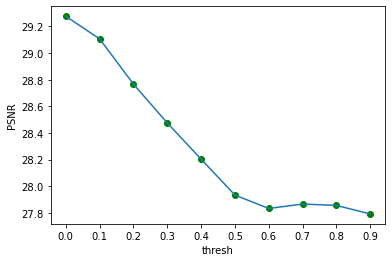

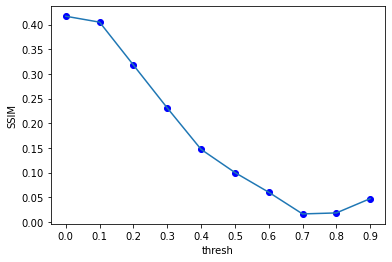

Testing for threshold = 0.0
Keeping only 99.75 % of the DCT coefficients of Y Matrix
Keeping only 99.99 % of the DCT coefficients of U Matrix
Keeping only 99.99 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 784496
Compressed File Size: 727218
Achieved Compression Ratio: 1.079
Achieved Peak Signal to Noise Ratio: 29.356
Achieved SSIM: 0.402
Testing for threshold = 0.1
Keeping only 87.33 % of the DCT coefficients of Y Matrix
Keeping only 98.06 % of the DCT coefficients of U Matrix
Keeping only 99.62 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 784496
Compressed File Size: 718185
Achieved Compression Ratio: 1.092
Achieved Peak Signal to Noise Ratio: 29.122
Achieved SSIM: 0.363
Testing for threshold = 0.2
Keeping only 67.63 % of the DCT coefficients of Y Matrix
Keeping only 83.93 % of the DCT coefficients of U Matrix
Keeping only 87.41 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 784496
Compressed F

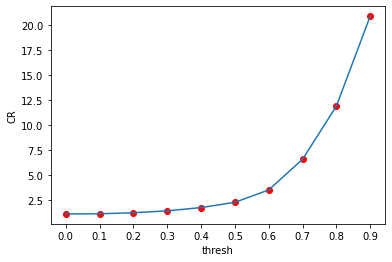

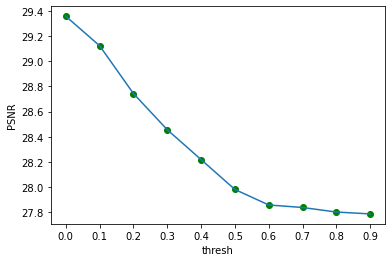

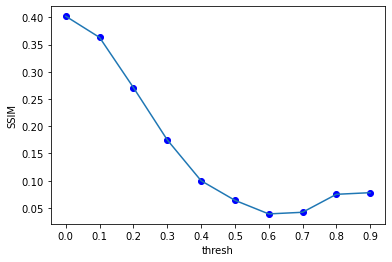

Testing for threshold = 0.0
Keeping only 99.69 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.94 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 695984
Compressed File Size: 645412
Achieved Compression Ratio: 1.078
Achieved Peak Signal to Noise Ratio: 28.567
Achieved SSIM: 0.229
Testing for threshold = 0.1
Keeping only 79.6 % of the DCT coefficients of Y Matrix
Keeping only 99.92 % of the DCT coefficients of U Matrix
Keeping only 98.65 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 695984
Compressed File Size: 623963
Achieved Compression Ratio: 1.115
Achieved Peak Signal to Noise Ratio: 28.391
Achieved SSIM: 0.176
Testing for threshold = 0.2
Keeping only 57.33 % of the DCT coefficients of Y Matrix
Keeping only 87.42 % of the DCT coefficients of U Matrix
Keeping only 86.83 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 695984
Compressed Fi

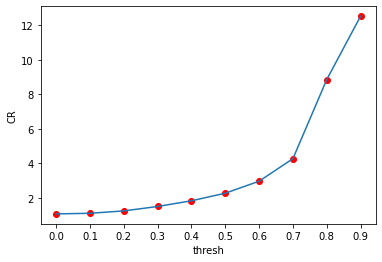

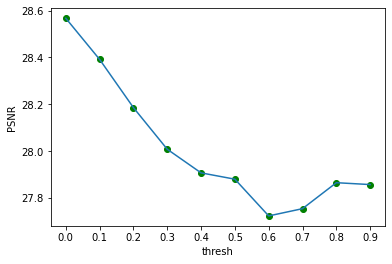

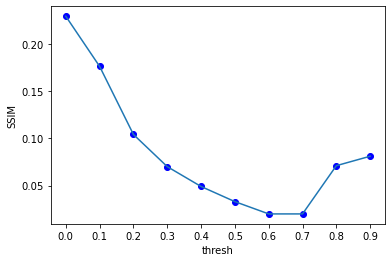

Testing for threshold = 0.0
Keeping only 99.85 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 631496
Compressed File Size: 601505
Achieved Compression Ratio: 1.05
Achieved Peak Signal to Noise Ratio: 29.515
Achieved SSIM: 0.374
Testing for threshold = 0.1
Keeping only 93.13 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 631496
Compressed File Size: 597265
Achieved Compression Ratio: 1.057
Achieved Peak Signal to Noise Ratio: 29.367
Achieved SSIM: 0.355
Testing for threshold = 0.2
Keeping only 75.74 % of the DCT coefficients of Y Matrix
Keeping only 87.54 % of the DCT coefficients of U Matrix
Keeping only 87.55 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 631496
Compressed Fi

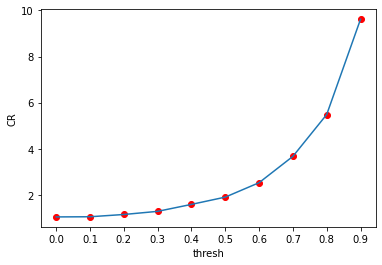

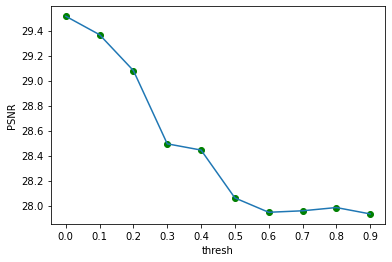

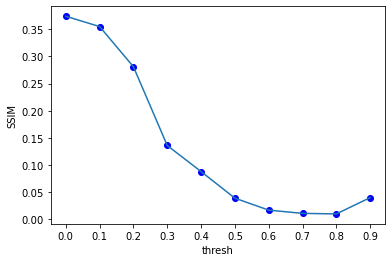

Testing for threshold = 0.0
Keeping only 99.71 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 687829
Compressed File Size: 636678
Achieved Compression Ratio: 1.08
Achieved Peak Signal to Noise Ratio: 29.36
Achieved SSIM: 0.357
Testing for threshold = 0.1
Keeping only 73.33 % of the DCT coefficients of Y Matrix
Keeping only 99.95 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 687829
Compressed File Size: 596733
Achieved Compression Ratio: 1.153
Achieved Peak Signal to Noise Ratio: 29.076
Achieved SSIM: 0.293
Testing for threshold = 0.2
Keeping only 56.03 % of the DCT coefficients of Y Matrix
Keeping only 87.51 % of the DCT coefficients of U Matrix
Keeping only 87.53 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 687829
Compressed Fil

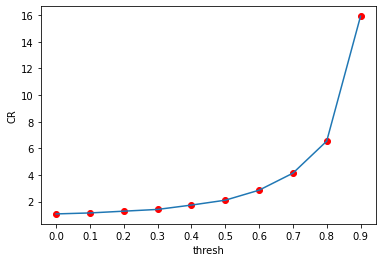

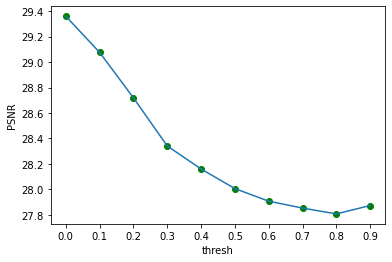

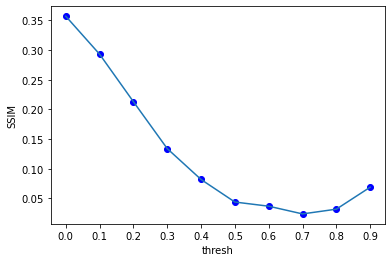

Testing for threshold = 0.0
Keeping only 99.67 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 837591
Compressed File Size: 772321
Achieved Compression Ratio: 1.085
Achieved Peak Signal to Noise Ratio: 29.385
Achieved SSIM: 0.386
Testing for threshold = 0.1
Keeping only 82.89 % of the DCT coefficients of Y Matrix
Keeping only 98.91 % of the DCT coefficients of U Matrix
Keeping only 99.99 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 837591
Compressed File Size: 763488
Achieved Compression Ratio: 1.097
Achieved Peak Signal to Noise Ratio: 29.051
Achieved SSIM: 0.322
Testing for threshold = 0.2
Keeping only 58.66 % of the DCT coefficients of Y Matrix
Keeping only 86.7 % of the DCT coefficients of U Matrix
Keeping only 87.51 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 837591
Compressed Fi

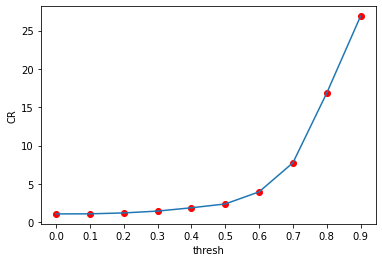

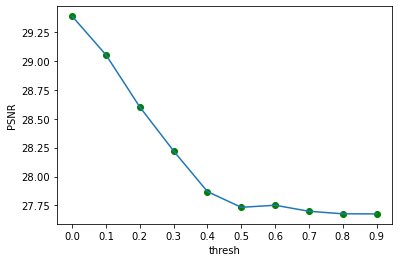

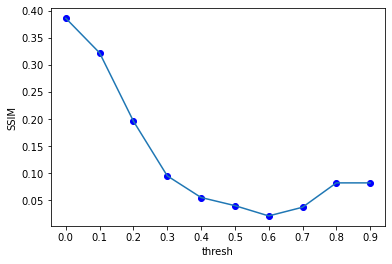

Testing for threshold = 0.0
Keeping only 99.84 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 748039
Compressed File Size: 693910
Achieved Compression Ratio: 1.078
Achieved Peak Signal to Noise Ratio: 29.385
Achieved SSIM: 0.389
Testing for threshold = 0.1
Keeping only 93.1 % of the DCT coefficients of Y Matrix
Keeping only 99.98 % of the DCT coefficients of U Matrix
Keeping only 99.97 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 748039
Compressed File Size: 692507
Achieved Compression Ratio: 1.08
Achieved Peak Signal to Noise Ratio: 29.27
Achieved SSIM: 0.367
Testing for threshold = 0.2
Keeping only 78.31 % of the DCT coefficients of Y Matrix
Keeping only 87.48 % of the DCT coefficients of U Matrix
Keeping only 87.51 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 748039
Compressed File

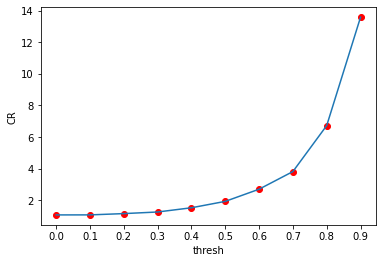

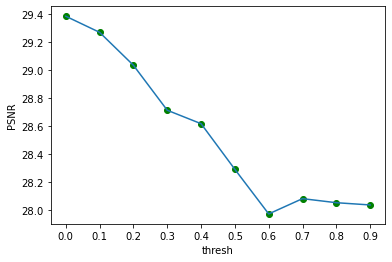

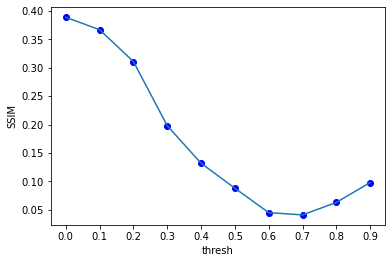

Testing for threshold = 0.0
Keeping only 99.84 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 546270
Compressed File Size: 555221
Achieved Compression Ratio: 0.984
Achieved Peak Signal to Noise Ratio: 28.278
Achieved SSIM: 0.183
Testing for threshold = 0.1
Keeping only 91.94 % of the DCT coefficients of Y Matrix
Keeping only 99.62 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 546270
Compressed File Size: 549086
Achieved Compression Ratio: 0.995
Achieved Peak Signal to Noise Ratio: 28.184
Achieved SSIM: 0.161
Testing for threshold = 0.2
Keeping only 76.03 % of the DCT coefficients of Y Matrix
Keeping only 86.85 % of the DCT coefficients of U Matrix
Keeping only 87.52 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 546270
Compressed F

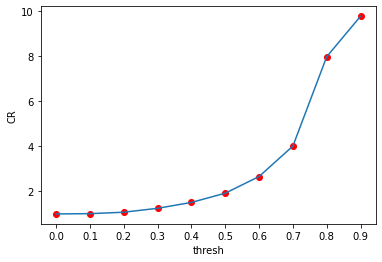

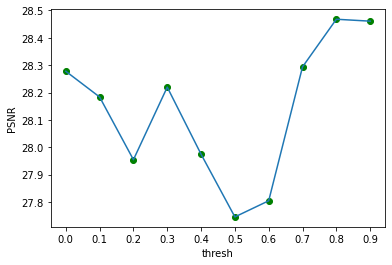

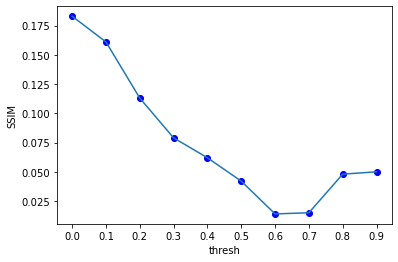

Testing for threshold = 0.0
Keeping only 99.82 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 712184
Compressed File Size: 664328
Achieved Compression Ratio: 1.072
Achieved Peak Signal to Noise Ratio: 29.398
Achieved SSIM: 0.414
Testing for threshold = 0.1
Keeping only 94.38 % of the DCT coefficients of Y Matrix
Keeping only 99.98 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 712184
Compressed File Size: 661201
Achieved Compression Ratio: 1.077
Achieved Peak Signal to Noise Ratio: 29.295
Achieved SSIM: 0.402
Testing for threshold = 0.2
Keeping only 79.53 % of the DCT coefficients of Y Matrix
Keeping only 87.52 % of the DCT coefficients of U Matrix
Keeping only 87.6 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 712184
Compressed Fi

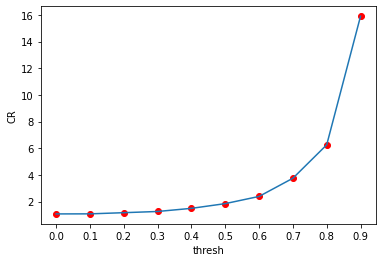

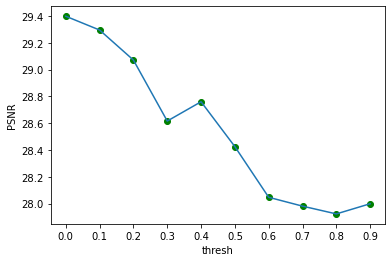

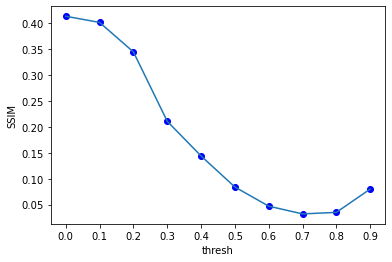

Testing for threshold = 0.0
Keeping only 99.93 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 773105
Compressed File Size: 708582
Achieved Compression Ratio: 1.091
Achieved Peak Signal to Noise Ratio: 29.465
Achieved SSIM: 0.412
Testing for threshold = 0.1
Keeping only 93.92 % of the DCT coefficients of Y Matrix
Keeping only 99.98 % of the DCT coefficients of U Matrix
Keeping only 99.89 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 773105
Compressed File Size: 708358
Achieved Compression Ratio: 1.091
Achieved Peak Signal to Noise Ratio: 29.324
Achieved SSIM: 0.389
Testing for threshold = 0.2
Keeping only 79.88 % of the DCT coefficients of Y Matrix
Keeping only 87.81 % of the DCT coefficients of U Matrix
Keeping only 87.48 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 773105
Compressed F

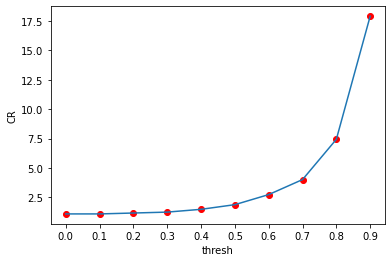

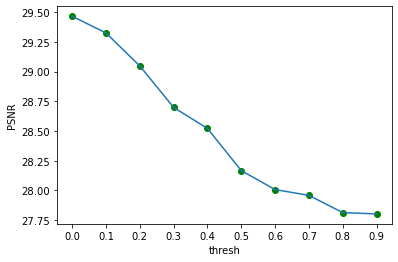

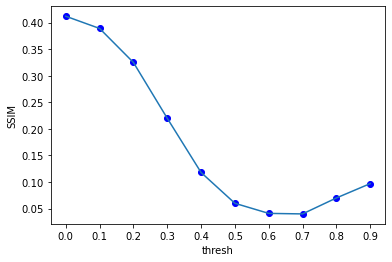

Testing for threshold = 0.0
Keeping only 99.91 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.96 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 625778
Compressed File Size: 582307
Achieved Compression Ratio: 1.075
Achieved Peak Signal to Noise Ratio: 29.273
Achieved SSIM: 0.343
Testing for threshold = 0.1
Keeping only 92.3 % of the DCT coefficients of Y Matrix
Keeping only 96.66 % of the DCT coefficients of U Matrix
Keeping only 99.04 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 625778
Compressed File Size: 579705
Achieved Compression Ratio: 1.079
Achieved Peak Signal to Noise Ratio: 29.11
Achieved SSIM: 0.29
Testing for threshold = 0.2
Keeping only 77.33 % of the DCT coefficients of Y Matrix
Keeping only 81.99 % of the DCT coefficients of U Matrix
Keeping only 87.05 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 625778
Compressed File

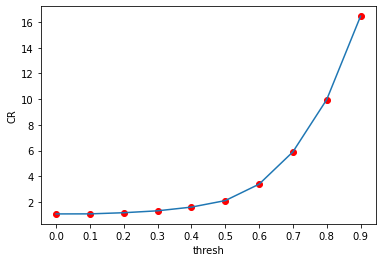

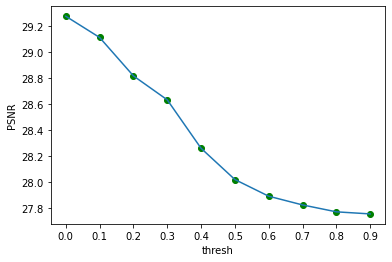

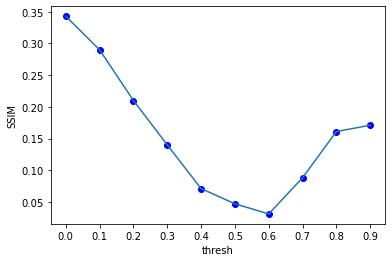

Testing for threshold = 0.0
Keeping only 99.87 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 788470
Compressed File Size: 747085
Achieved Compression Ratio: 1.055
Achieved Peak Signal to Noise Ratio: 29.476
Achieved SSIM: 0.414
Testing for threshold = 0.1
Keeping only 91.84 % of the DCT coefficients of Y Matrix
Keeping only 99.91 % of the DCT coefficients of U Matrix
Keeping only 99.96 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 788470
Compressed File Size: 741575
Achieved Compression Ratio: 1.063
Achieved Peak Signal to Noise Ratio: 29.29
Achieved SSIM: 0.386
Testing for threshold = 0.2
Keeping only 75.43 % of the DCT coefficients of Y Matrix
Keeping only 87.63 % of the DCT coefficients of U Matrix
Keeping only 87.54 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 788470
Compressed Fi

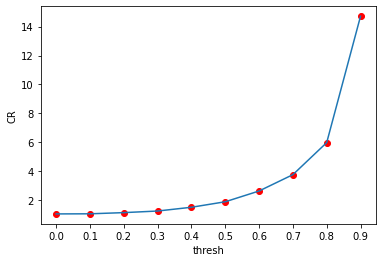

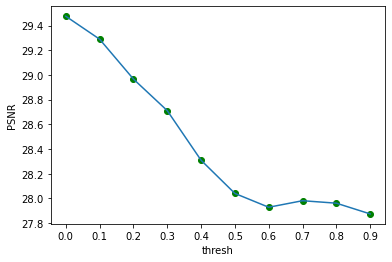

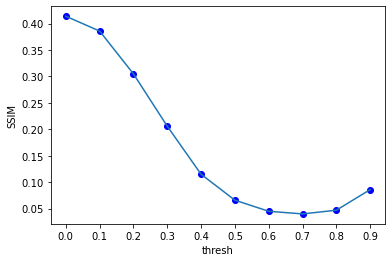

In [50]:
# folderName = 'Kodak'
# for fileName in (os.listdir(folderName)):
#     imagePath = os.path.join(folderName, fileName)
#     image = load_image(imagePath)
#     thresh = 0.0
#     threshMax = 0.9
#     step = 0.1
#     i=0
#     noOfMetrics = 3 
#     eval_data = np.zeros(((int((threshMax-thresh)/step))+1, noOfMetrics + 1), dtype=float)#col1=thresh, col2=cr, col3=psnr, col4=ssim
#     while thresh<=threshMax:
#         eval_data[i][0] = thresh
#         print("Testing for threshold = "+str(thresh))
#         X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )#DCT Transform 
#         X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
#         print("Metrics otained: ")
#         eval_data[i][1] = cr(image, X_compressed)
#         eval_data[i][2] = psnr(image, X_reconstructed)
#         eval_data[i][3] = ssim(image, X_reconstructed)
#         thresh+=0.1
#         i+=1
#     print("Data obtained after evaluation: ")
#     print(eval_data)
#     PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')